# Практика по базовой математической статистике для Data scientist

# Практика 3 - построение доверительной оценки

На практическом занятии научимся строить доверительные интервалы и выделять аномалии при помощи python. 

- Строим доверительный интервал для цен акций из yahoo finance при помощи scipy, numpy, pandas
-  Делаем выводы по наличию или отсутствию аномальных событий

Для начала импортируем все полезные библитеки и настроим ноутбук

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
from scipy import *
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

В этой практике мы поработаем с реальными финансовыми данными. 
Наверняка каждый из нас хоть раз покупал доллары в надежде немного заработать на разнице курсов покупки и продажи. Но не каждый знет, чтоо помимо валют есть еще и другие финансовые инструменты - например, акции или облигации, с которыми работаю профессиональные инвесторы на специальной площадке для купли и продаже - бирже.

Данные о ценах финансовых инструментов называются котировками, и сегодня мы с вами представим себя инвесторами и проанализируем реальные котировки самых настоящих акций.

Мы будем доставать их из сервиса yahoo finance, и для этого помощи bash магии установим несколько нужных библиотек.

In [2]:
%%bash
pip install yahoo-finance

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
%%bash
pip install pandas-datareader

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import pandas_datareader as pdr
from datetime import datetime

In [5]:
# Собираем котировки за интересующий период.
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 8, 31)

In [6]:
df = pdr.get_data_yahoo(symbols="GOOG", start=start_date, end=end_date)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 414 entries, 2018-01-02 to 2019-08-23
Data columns (total 6 columns):
High         414 non-null float64
Low          414 non-null float64
Open         414 non-null float64
Close        414 non-null float64
Volume       414 non-null int64
Adj Close    414 non-null float64
dtypes: float64(5), int64(1)
memory usage: 22.6 KB


In [8]:
# Переведем загловки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

,high,low,open,close,volume,adj close
Date,,,,,,
2018-01-02,1066.939941,1045.229980,1048.339966,1065.000000,1237600,1065.000000
2018-01-03,1086.290039,1063.209961,1064.310059,1082.479980,1430200,1082.479980
2018-01-04,1093.569946,1084.001953,1088.000000,1086.400024,1004600,1086.400024
2018-01-05,1104.250000,1092.000000,1094.000000,1102.229980,1279100,1102.229980
2018-01-08,1111.270020,1101.619995,1102.229980,1106.939941,1047600,1106.939941


Для изучения выберем разницу между ценой закрытия и ценой открытия.

In [9]:
# Готовим новую метрику.
df["diff_price"] = df.close - df.open

Для построения доверительного интервала необходимо, чтобы исследумая величина была распределена по Гауссову закону.
Поэтому воспользуемся функцией из первой практики для разведочного анализа.

Text(0.5,1,'График разниы между ценой закрытия и открытия')

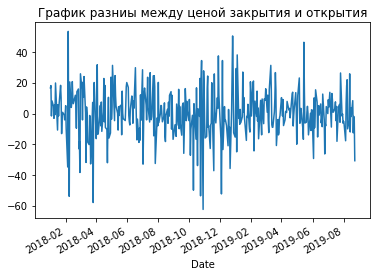

In [10]:
df.diff_price.plot()
plt.title("График разниы между ценой закрытия и открытия")

In [11]:
def my_basic_research(df=df, column = "diff_price"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sns.distplot(df[column])
    plt.title("Распределение метрики")

Базовые метрики
count    414.000000
mean       0.263608
std       15.833054
min      -62.389954
25%       -7.427490
50%       -0.140015
75%        9.090088
max       53.419922
Name: diff_price, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
-1.900024    2
-4.140015    2
 3.479980    2
-6.169922    2
 2.079956    2
Name: diff_price, dtype: int64
------------------------------------
Эксцесс  1.82234052150468
Ассиметрия  -0.37125785357663094


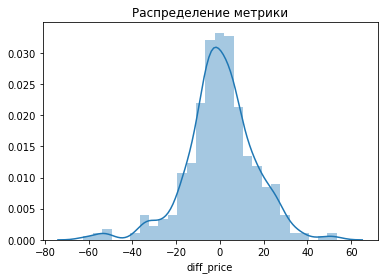

In [12]:
my_basic_research(column = "diff_price")

В целом наше распределение близко к нормальному, несмотря на остроконечный пик и наличие выбросов. 
Однако для уверенности проверим его при помощи графика QQ plot - https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot

График сравнивает квантили выборки и выбранноого распределения - в нашем случае, нормального.

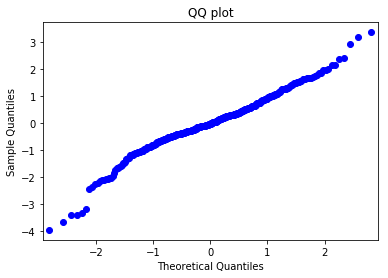

In [13]:
sm.qqplot(df.diff_price, fit = True)
plt.title("QQ plot")
plt.show()

Кажется, что можно использовать стандартные доверительные интервалы для нормального распределения. Для этого воспользуемся функцией https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [14]:
def my_norm_confidence(df=df, column = "diff_price", alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [15]:
confidence = my_norm_confidence()
print(confidence)

(-30.76860816831546, 31.295824835453892)


При доверительной вероятности 95 % средняя разница между ценой закрытия и открытия не выйдет за этот интервал.
Отметим на графике полученный коридор.

Text(0.5,1,'Доверительный интервал')

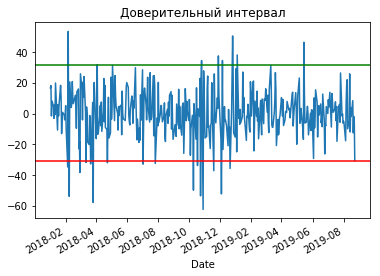

In [16]:
df.diff_price.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

## Отбор аномалий при помощи доверительного интервала

А если нам понадобится отметить аномальные события, выходящие за зеленую границу, то это можно сделать следующим образом

In [17]:
df["anomaly_big"] = np.where(df.diff_price > confidence[1], 1,0)

Теперь они готовы к дальнейшему исследованию.

In [18]:
df[df.anomaly_big == 1].describe()

,high,low,open,close,volume,adj close,diff_price,anomaly_big
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.0
mean,1088.186780,1040.519098,1044.146002,1083.051978,2.577930e+06,1083.051978,38.905975,1.0
std,50.618170,50.943488,49.937315,49.617563,7.385681e+05,49.617563,8.221770,0.0
min,1028.718018,983.000000,989.010010,1025.140015,1.719200e+06,1025.140015,31.309937,1.0
25%,1054.092499,1018.459274,1019.470032,1053.339966,2.142750e+06,1053.339966,32.407516,1.0
50%,1076.454956,1029.093994,1033.424988,1071.089966,2.424350e+06,1071.089966,35.969971,1.0
75%,1101.607513,1035.342499,1045.827515,1084.822479,2.698075e+06,1084.822479,44.284973,1.0
max,1176.189941,1144.449951,1144.449951,1175.760010,4.187600e+06,1175.760010,53.419922,1.0


# Мини домашка

Необходимо построить для тех же данных доверительный интервал с доверительной вероятностью 90 %
Сколько аномальных событий находится выше верхней доверительной границы?